В одной из баз: hh или квартир, сделайте callback, который будет выводить на каждой эпохе следующее:

Текущую mae.
График mae по всем эпохам на обучающей и проверочной выборках.
Текущий scatterplot, где отображаются предсказанные и истинные значения.
Время обучения на эпохе, время обучения суммарное и сколько времени остаётся до конца обучения.
Изменял бы шаг обучения, если начинается “пила” на графике ошибки (mae), или график выходит на плато.
Сохраняет сеть с лучшей точностью в .h5 файл.
*желательно использовать clear_output и verbose=0

**callback должен быть самописный, нельзя использовать готовые

# Импорт библиотек

In [ ]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd
import random 
import math
from google.colab import drive
import time

import re
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

# Подключение к Гугл диску

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Lessons/Lesson6/moscow.csv', sep=";")
df = df.iloc[::2,:]
data = df.values
df.head(20)

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
2,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
4,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
6,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
8,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
10,1,Шелепиха м.,15п,9/36 К,NaN,NaN,44/14.7/19.2,12700000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,"1-комн. квартира в ЖК ""Сердце столицы"" на 9 эт..."
12,1,Улица Дмитриевского м.,2п,7/16 П,Л,Р,43/20/8,6500000.0,NaN,NaN,25.07.2019,14.0,Привлекательные,Предлагаю купить Однокомнатную квартиру с удоб...
14,1,Бульвар Рокоссовского м.,2п,2/5 К,Б,С,31/17/6,6000000.0,NaN,NaN,25.07.2019,15.0,Привлекательные,"Теплая, светлая квартира с высоким потолком в ..."
16,1,Марьина Роща м.,10п,7/14 П,2Б,NaN,38.9/20.9/8.5,8900000.0,NaN,NaN,25.07.2019,16.0,Привлекательные,"Продается 1-комн. квартира, площадью 38.9 м2 в..."
18,1,Марьино м.,20п,10/24 М-К,NaN,-,30.9/17.9/10,5999984.0,NaN,NaN,25.07.2019,16.0,Привлекательные,Предлагается уютная квартира в ЖК комфорт клас...


# Функции для парсинга данных

In [ ]:
def getHouseFloor(d):
  try:
    houseStr = d[3]
  except:
    houseStr = ""
  
  floor = 0
  
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/")
        floorStr = houseStr[:slashIndex]
        floor = int(floorStr)
      except:
        floor = 0
    
  return floor
  
  
def getCountRooms(d):
  num = d[0]
  try:
    if (num == num):
      num = int(num[0])
  except:
    num = 0
  return num


def getMetroDistance(d):
  metroDistanceStr = d[2]
  
  metroDistance = 0
  metroDistanceType = 0
  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2

      metroDistanceStr = metroDistanceStr[:-1]

      try:
        metroDistance = int(metroDistanceStr)
      except:
        metroDistance = 0
      

  if (metroDistanceType == 2):
    metroDistance += 7
  if (metroDistanceType == 0):
    metroDistance += 14

  return metroDistance


def getArea(d):
  areaStr = d[6] 
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") 
    try:
      area = float(areaStr[:slashIndex]) 
    except:
      area = 0 
  else:
    area = 0 
    
  return area


def getCost(d):
  costStr = d[7] 
  
  try:
    cost = float(costStr) 
  except:
    cost = 0  
  
  return cost


def getComment(d):
  commentStr = d[-1]
  
  return commentStr


def getAllParameters(d):
 
  floor = getHouseFloor(d)
  metroDistance = getMetroDistance(d)
  area = getArea(d)

  out = [floor]
  out.append(metroDistance)
  out.append(area)
  
  return out


def getXTrain(data):
  
  xTrain = [getAllParameters(d) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain


def getXTrainC(data):

  xTrainC = [getComment(d) for d in data]
  xTrainC = np.array(xTrain)

  return xTrainC


def getYTrain(data):
   
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

In [ ]:
oneRoomMask = [getCountRooms(d) == 1 for d in data]
data1 = data[oneRoomMask]
print(data.shape)
print(data1.shape)


(126268, 14)
(62601, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [ ]:
print(xTrain.shape)

(62601, 3)


# Функция-Токенайзер

In [ ]:
def text2Words(text):

  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower()
  
  
  words = []
  currWord = ""
  
  for symbol in text:
    
    if (symbol != "\ufeff"):
      if (symbol != " "):
        currWord += symbol
      else:
        if (currWord != ""): 
          words.append(currWord)
          currWord = ""

  if (currWord != ""):
        words.append(currWord)
  
  return words


def createVocabulary(allWords):
  
  wCount = dict.fromkeys(allWords, 0)

  for word in allWords:
    wCount[word] += 1

  wordsList = list(wCount.items())
  wordsList.sort(key = lambda i:i[1], reverse=1)

  sortedWords = []

  for word in wordsList:
    sortedWords.append(word[0])

  wordIndexes = dict.fromkeys(allWords, 0)
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1

  return wordIndexes


def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  for word in words:
    
    wordIndex = 0
    wordInVocabulary = word in vocabulary
    

    if (wordInVocabulary):
      index = vocabulary[word]
      if (index < maxWordsCount):
        wordIndex = index
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)
  
  for x in trainVector:
    out[x] = 1
    
  return out


def changeSetTo01(trainSet, wordsCount):
  out = []
  
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
    
  return np.array(out)


def getXTrainComments(data):
  xTrainComments = []
  allTextComments = ""
  
  for d in data:
    currText = getComment(d)
    try: 
      if (currText == currText):
        allTextComments += currText + " "
    except:
      currText = "Нет комментария"
    xTrainComments.append(currText)
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)


def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = []

  for text in xTrainComments:
    currWords = text2Words(text)
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes)
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount)
  return xTrainCommentsIndexes


def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = []
  
  for text in xTrainComments:
    currWords = text2Words(text)
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount)
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes)
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen)
  return xTrainCommentsIndexes

# Подготовка данных

In [ ]:
xTrainC, allTextComments = getXTrainComments(data1)
allWords = text2Words(allTextComments)
allWords = allWords[::10]
vocabulary = createVocabulary(allWords)
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

(62601, 3)
(62601, 2000)
(62601,)


In [ ]:

xScalerArea = StandardScaler()
xScalerFloor = StandardScaler()
xScalerDisMetro = StandardScaler()
xScalerArea.fit(xTrain[:,-1].reshape(-1, 1))
xScalerFloor.fit(xTrain[:,0].reshape(-1, 1))
xScalerDisMetro.fit(xTrain[:,1].reshape(-1, 1))
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScalerArea.transform(xTrain[:,-1].reshape(-1, 1)).flatten()
xTrainScaled[:,0] = xScalerFloor.transform(xTrain[:,0].reshape(-1, 1)).flatten()
xTrainScaled[:,1] = xScalerDisMetro.transform(xTrain[:,1].reshape(-1, 1)).flatten()


print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

(62601, 3)
[35.  12.  64.1]
[ 2.87483925 -0.08772151  0.76496095]


In [ ]:
yScaler = StandardScaler()
yScaler.fit(yTrain.reshape(-1, 1))
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))


print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(62601, 1)
19500000.0
[0.24401087]


In [ ]:
splitVal = 0.2
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal

## Создание Callback

In [ ]:
def show_mae(mae_list):
  plt.plot(mae_list, 
         label='MAE на каждую эпоху')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя абсолютная ошибка')
  plt.legend()
  plt.show()

In [ ]:
def show(logs):
  plt.plot(logs[0], 
         label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(logs[1], 
          label='Средняя абсолютная ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя абсолютная ошибка')
  plt.legend()
  plt.show()

In [ ]:
def check_saw(logs, lr, upper_range=1.5, lower_range=0.02):
  a = 0
  logs = logs[0]
  average_sum = sum(logs) / len(logs)  # Среднее значение
  for num in logs:
    a += abs(num - average_sum) / len(logs)  # Дисперсия
  if a > upper_range:
    lr *= 0.1
    model.compile(optimizer=Adam(lr=lr), loss='mse')
  elif a < lower_range:
    lr *= 10
    model.compile(optimizer=Adam(lr=lr), loss='mse')

In [ ]:
list_mae = list()
list_log_1 = list()
list_log_2 = list()
time_for_step = 0


In [ ]:
def on_epoch_end(epoch, logs):

  pred = model.predict([xTrainScaled[~valMask], xTrainC01[~valMask]])
  predUnscaled = yScaler.inverse_transform(pred).flatten()
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[~valMask]).flatten()
  sum = 0
  n = len(predUnscaled)
  for ii in range(n):
    sum += abs(predUnscaled[ii] - yTrainUnscaled[ii])
  sum /= n * 1000
  list_mae.append(sum)
  if currtime == startTime:
    time_for_step = time.time() - currtime

  list_log_1.append(logs["loss"])
  list_log_2.append(logs["val_loss"])

  print("Эпоха", epoch + 1)
  print(f"MAE: {sum}")
  show_mae(list_mae)
  show([list_log_1, list_log_2])
  print(f"Время обучения эпохи: {time.time() - currtime}с")
  curtime = time.time()
  print(f"Время с начала обучения: {time.time() - startTime}с")
  print(f"Время осталось (примерно): {(epochs - epoch) * time_for_step}с")
  # check_saw(list_log_1, lr)
  if logs["loss"] == min(list_log_1):
    model.save("best_model.h5")
    print("Модель сохранена.")
  print()

  # print(logs)
  # print("Эпоха", epoch + 1, f"врема: {round(time.time() - curtime)}с")

pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

# Создание модели и обучение модели

In [ ]:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')

print(model.summary())



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 10)           40          ['input_3[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 250)          500250      ['input_4[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Эпоха 1
MAE: 5568.546100875793


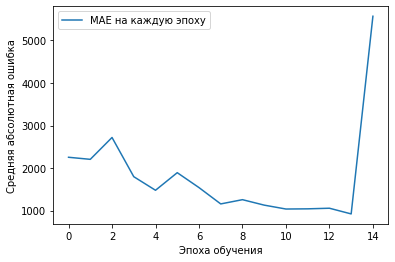

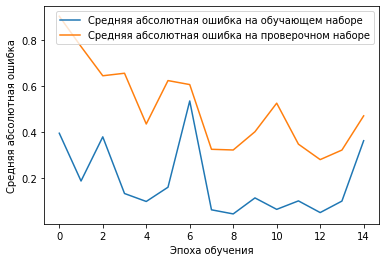

Время обучения эпохи: 23.882136344909668с
Время с начала обучения: 23.88222861289978с
Время осталось (примерно): 470.8934450149536с

Эпоха 2
MAE: 2037.3818329699002


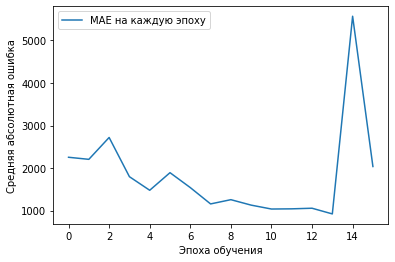

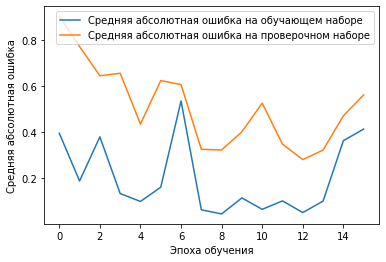

Время обучения эпохи: 40.4167103767395с
Время с начала обучения: 40.417539834976196с
Время осталось (примерно): 761.4861280918121с

Эпоха 3
MAE: 1851.2843078791445


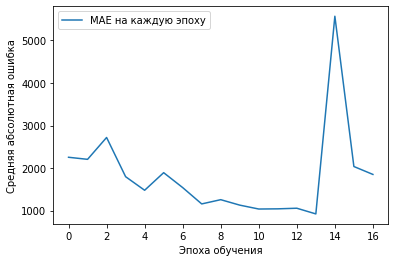

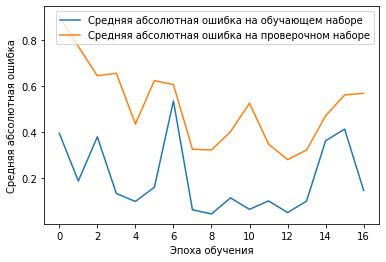

Время обучения эпохи: 56.3784294128418с
Время с начала обучения: 56.379191398620605с
Время осталось (примерно): 1008.708420753479с

Эпоха 4
MAE: 1545.0402038777515


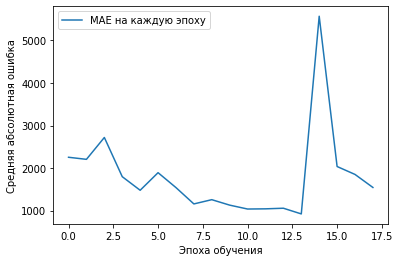

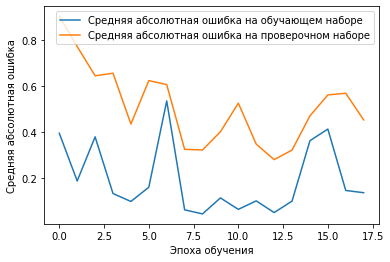

Время обучения эпохи: 71.09240317344666с
Время с начала обучения: 71.09316158294678с
Время осталось (примерно): 1202.5606667995453с

Эпоха 5
MAE: 1532.6829468109504


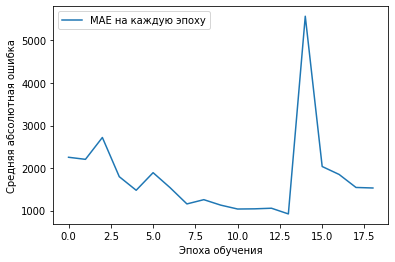

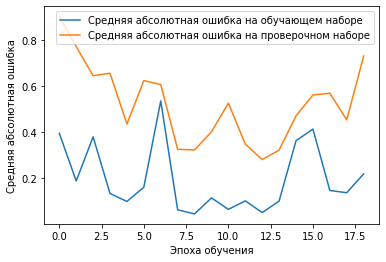

Время обучения эпохи: 86.93832874298096с
Время с начала обучения: 86.9391303062439с
Время осталось (примерно): 1385.5889129638672с

Эпоха 6
MAE: 1709.4552978929037


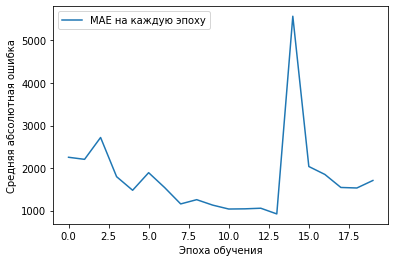

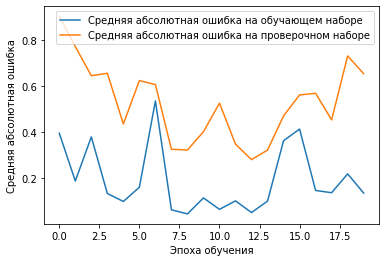

Время обучения эпохи: 100.92704677581787с
Время с начала обучения: 100.92784976959229с
Время осталось (примерно): 1508.826574087143с

Эпоха 7
MAE: 1175.434286683729


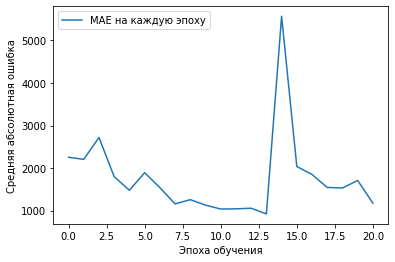

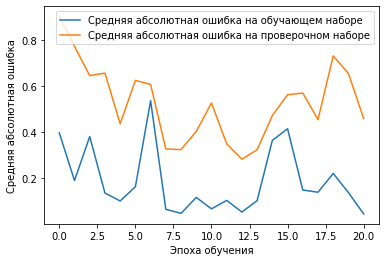

Время обучения эпохи: 116.66698575019836с
Время с начала обучения: 116.66775631904602с
Время осталось (примерно): 1628.5871510505676с
Модель сохранена.

Эпоха 8
MAE: 1254.8490126175009


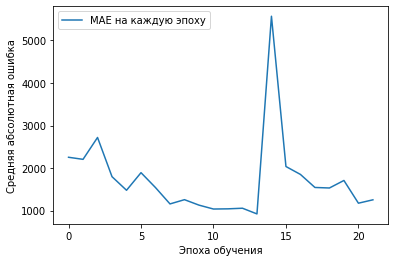

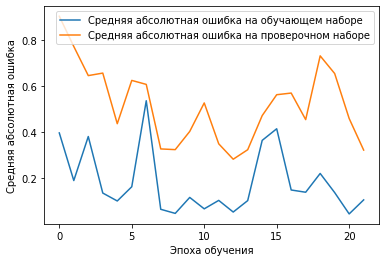

Время обучения эпохи: 130.95162773132324с
Время с начала обучения: 130.95170521736145с
Время осталось (примерно): 1698.363641500473с

Эпоха 9
MAE: 1185.575472104866


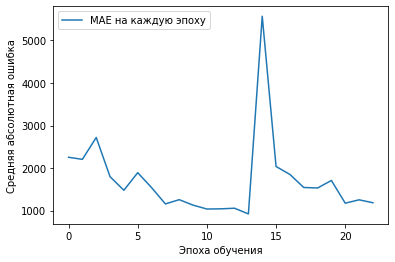

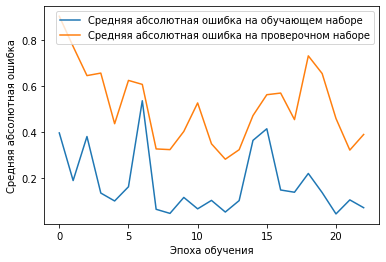

Время обучения эпохи: 145.337797164917с
Время с начала обучения: 145.33856582641602с
Время осталось (примерно): 1740.2866172790527с

Эпоха 10
MAE: 1057.20315365147


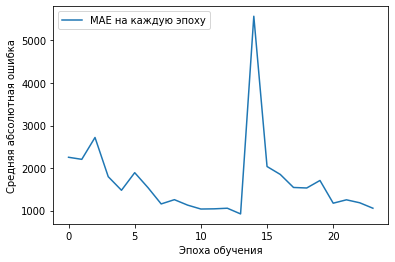

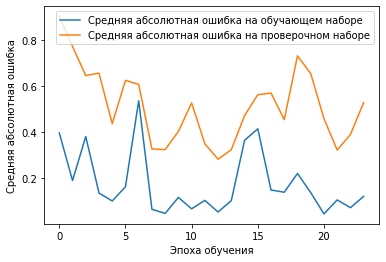

Время обучения эпохи: 160.9388885498047с
Время с начала обучения: 160.93897104263306с
Время осталось (примерно): 1766.6471455097198с

Эпоха 11
MAE: 1028.2126806839342


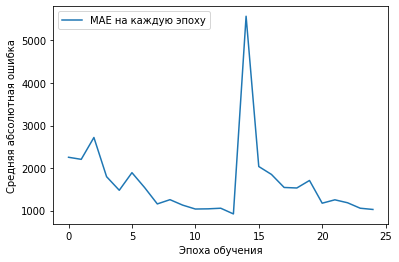

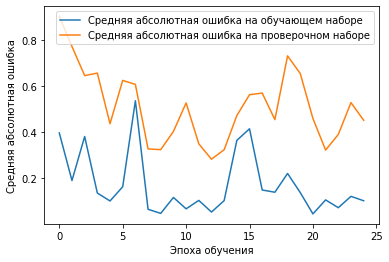

Время обучения эпохи: 176.56386423110962с
Время с начала обучения: 176.5647051334381с
Время осталось (примерно): 1762.3584747314453с

Эпоха 12
MAE: 1067.454735332431


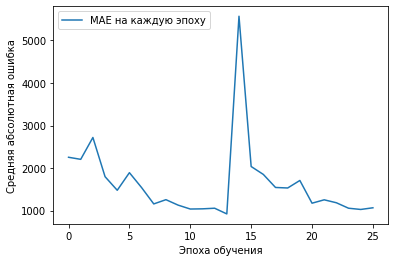

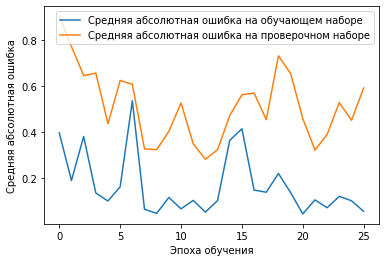

Время обучения эпохи: 192.5249741077423с
Время с начала обучения: 192.52578997612с
Время осталось (примерно): 1726.7023751735687с

Эпоха 13
MAE: 908.7678266526167


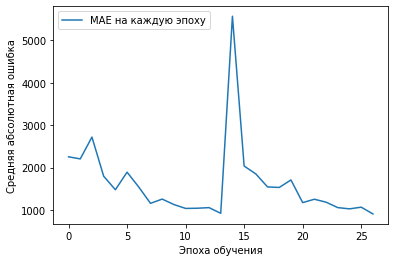

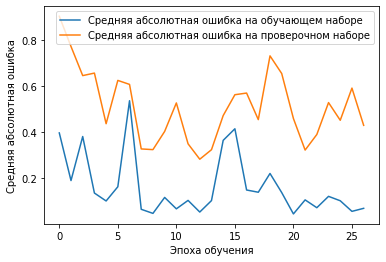

Время обучения эпохи: 208.7217321395874с
Время с начала обучения: 208.72254872322083с
Время осталось (примерно): 1666.7678260803223с

Эпоха 14
MAE: 927.7081016413638


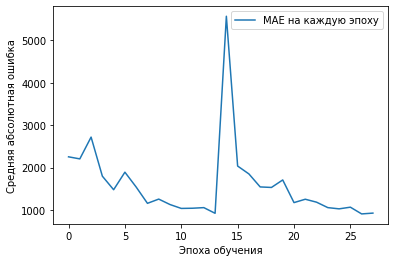

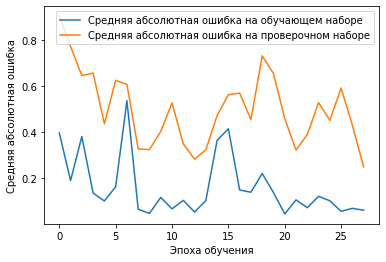

Время обучения эпохи: 223.18272185325623с
Время с начала обучения: 223.18285274505615с
Время осталось (примерно): 1559.9645607471466с

Эпоха 15
MAE: 828.2276744120442


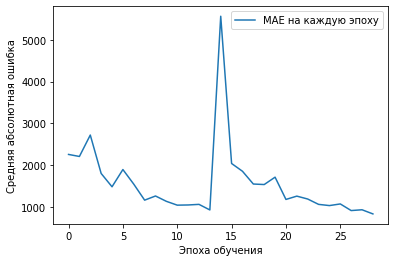

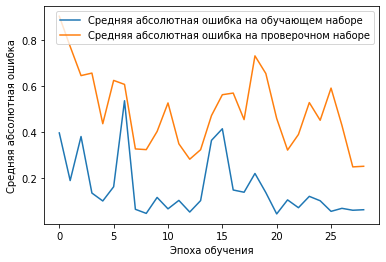

Время обучения эпохи: 239.44925951957703с
Время с начала обучения: 239.4493374824524с
Время осталось (примерно): 1434.6521229743958с

Эпоха 16
MAE: 1026.2411523505687


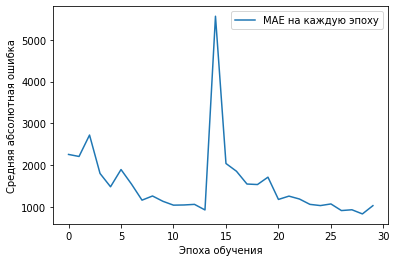

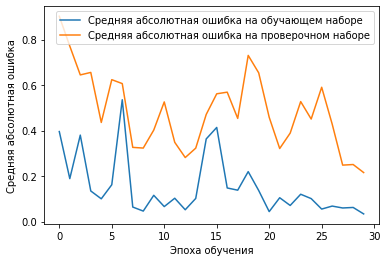

Время обучения эпохи: 253.27142238616943с
Время с начала обучения: 253.27227544784546с
Время осталось (примерно): 1264.672828912735с
Модель сохранена.

Эпоха 17
MAE: 1042.8646489031626


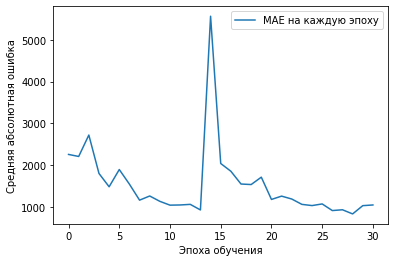

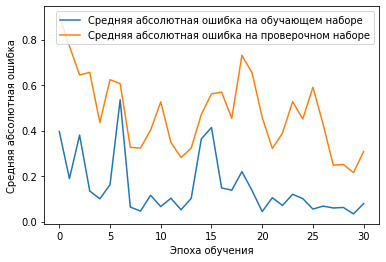

Время обучения эпохи: 267.90691328048706с
Время с начала обучения: 267.9077024459839с
Время осталось (примерно): 1070.2429027557373с

Эпоха 18
MAE: 774.5208406944578


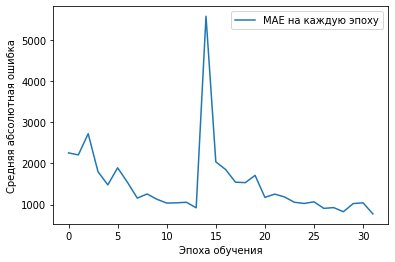

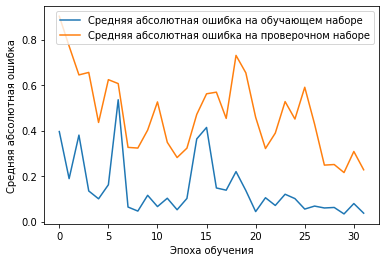

Время обучения эпохи: 284.81700015068054с
Время с начала обучения: 284.8317217826843с
Время осталось (примерно): 852.0949716567993с

Эпоха 19
MAE: 810.2904286201507


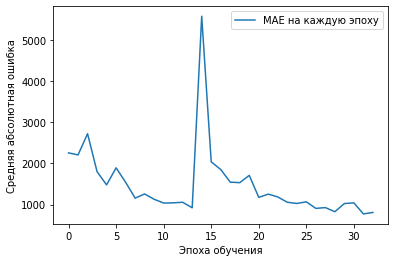

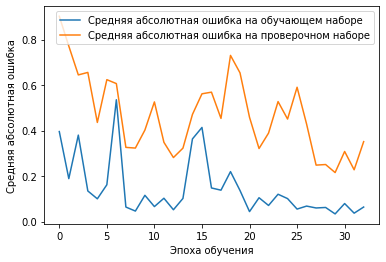

Время обучения эпохи: 303.7416441440582с
Время с начала обучения: 303.74193692207336с
Время осталось (примерно): 606.7833099365234с

Эпоха 20
MAE: 941.5126165069494


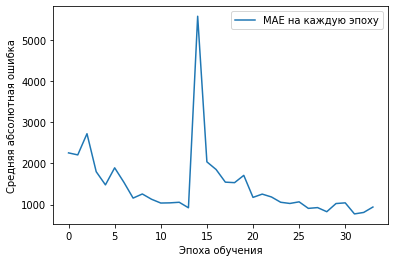

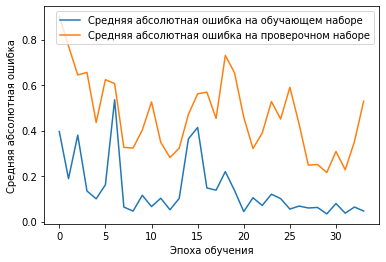

Время обучения эпохи: 318.06397676467896с
Время с начала обучения: 318.06406116485596с
Время осталось (примерно): 317.7170555591583с

Эпоха 21
MAE: 904.2172879406396


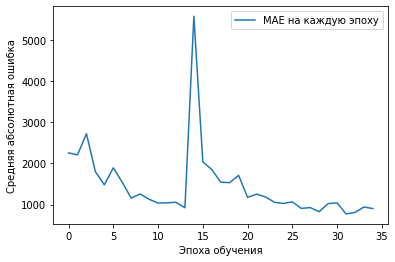

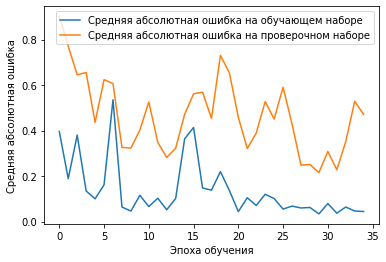

Время обучения эпохи: 332.90568828582764с
Время с начала обучения: 332.90658950805664с
Время осталось (примерно): 0.0с

Эпоха 22
MAE: 906.2477691035778


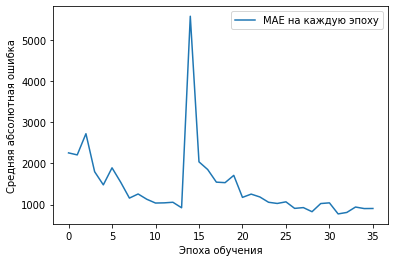

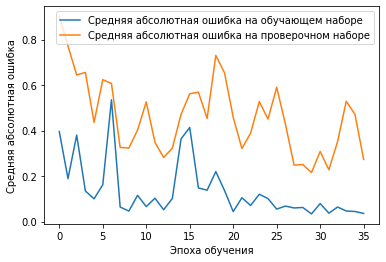

Время обучения эпохи: 348.85583901405334с
Время с начала обучения: 348.85594487190247с
Время осталось (примерно): -348.48382091522217с

Эпоха 23
MAE: 851.9972581195387


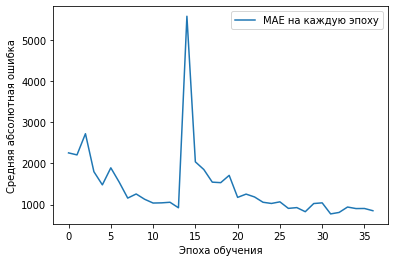

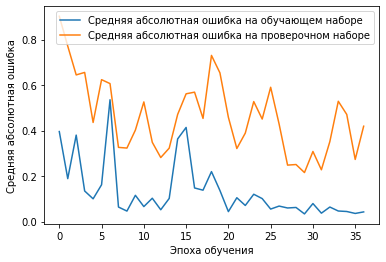

Время обучения эпохи: 365.41619539260864с
Время с начала обучения: 365.4162907600403с
Время осталось (примерно): -730.1463294029236с

Эпоха 24
MAE: 723.7570746157184


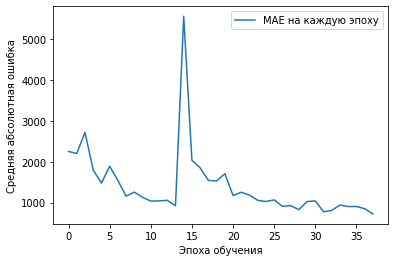

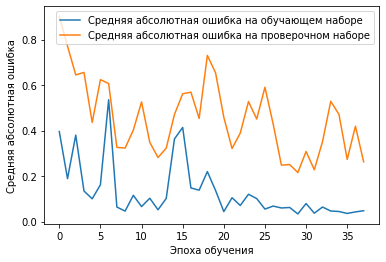

Время обучения эпохи: 380.270281791687с
Время с начала обучения: 380.270361661911с
Время осталось (примерно): -1139.7753231525421с

Эпоха 25
MAE: 940.8207959685343


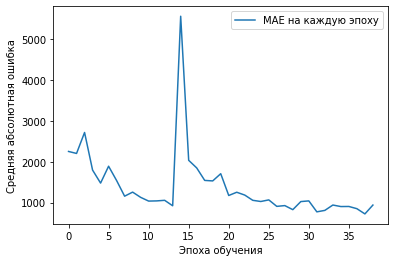

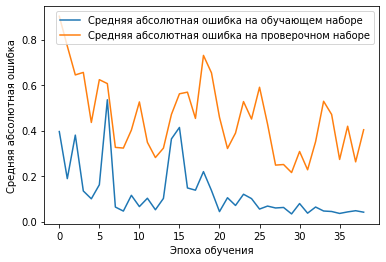

Время обучения эпохи: 394.81283378601074с
Время с начала обучения: 394.8137092590332с
Время осталось (примерно): -1577.8144550323486с

Эпоха 26
MAE: 775.816053878484


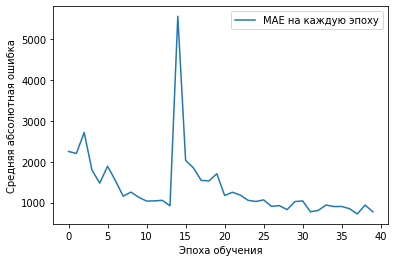

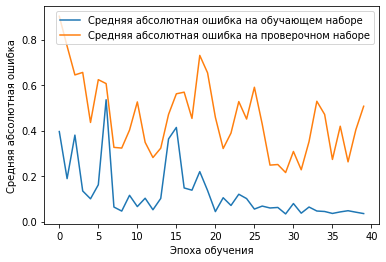

Время обучения эпохи: 411.1213598251343с
Время с начала обучения: 411.1214361190796с
Время осталось (примерно): -2053.7801837921143с

Эпоха 27
MAE: 648.0972700666586


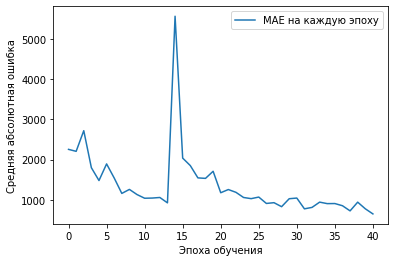

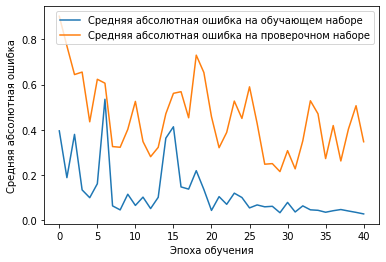

Время обучения эпохи: 425.6911954879761с
Время с начала обучения: 425.6912839412689с
Время осталось (примерно): -2551.9750714302063с
Модель сохранена.

Эпоха 28
MAE: 773.0914855121345


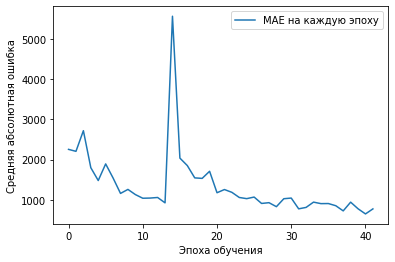

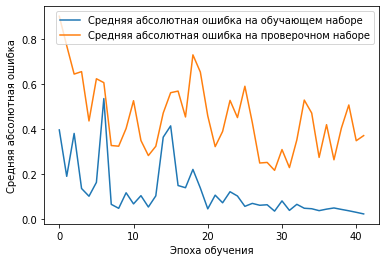

Время обучения эпохи: 442.2745587825775с
Время с начала обучения: 442.2753574848175с
Время осталось (примерно): -3093.5634713172913с
Модель сохранена.

Эпоха 29
MAE: 777.9207031231297


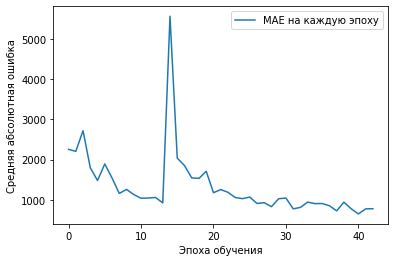

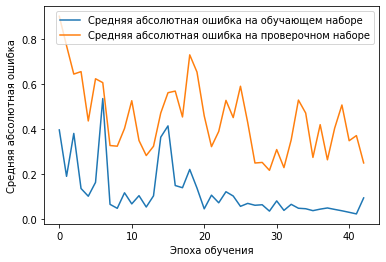

Время обучения эпохи: 457.0183017253876с
Время с начала обучения: 457.0183811187744с
Время осталось (примерно): -3653.476848602295с

Эпоха 30
MAE: 642.2777096230001


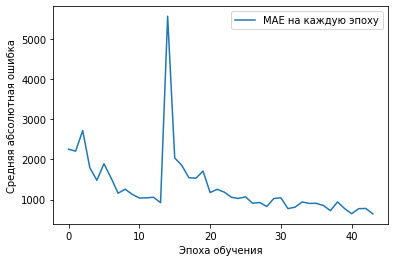

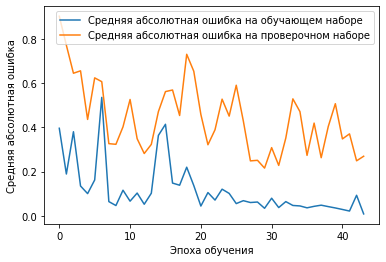

Время обучения эпохи: 471.4867150783539с
Время с начала обучения: 471.4874882698059с
Время осталось (примерно): -4240.3293306827545с
Модель сохранена.

Эпоха 31
MAE: 633.7946052908


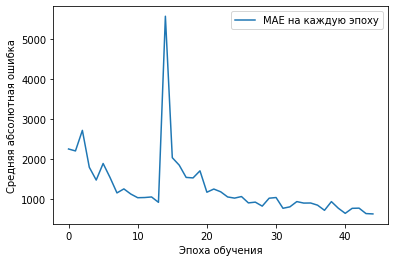

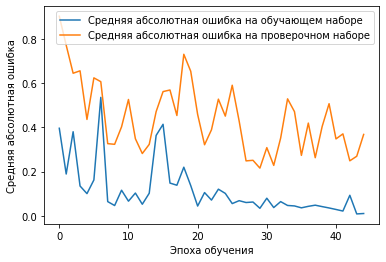

Время обучения эпохи: 487.6290235519409с
Время с начала обучения: 487.6298499107361с
Время осталось (примерно): -4872.659091949463с

Эпоха 32
MAE: 770.0947104476796


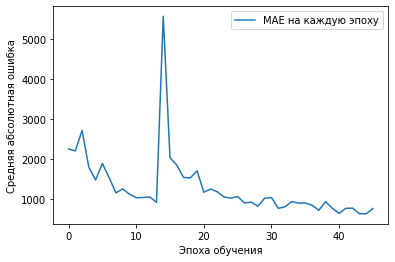

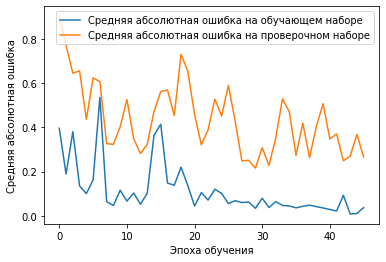

Время обучения эпохи: 503.69042468070984с
Время с начала обучения: 503.6905071735382с
Время осталось (примерно): -5536.805574655533с

Эпоха 33
MAE: 609.0236667292173


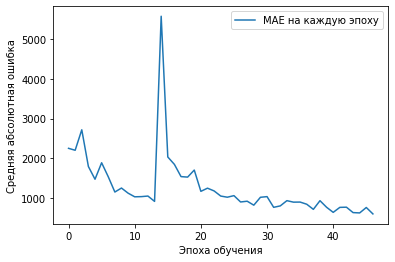

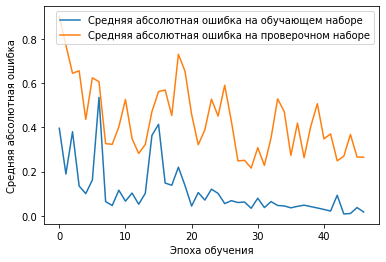

Время обучения эпохи: 518.5198655128479с
Время с начала обучения: 518.526496887207с
Время осталось (примерно): -6218.021292686462с

Эпоха 34
MAE: 691.0348980715862


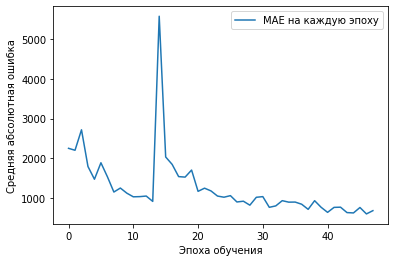

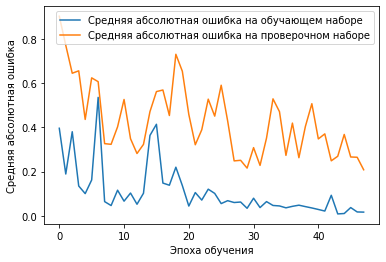

Время обучения эпохи: 535.0231447219849с
Время с начала обучения: 535.0276398658752с
Время осталось (примерно): -6950.809412479401с

Эпоха 35
MAE: 830.8542678384845


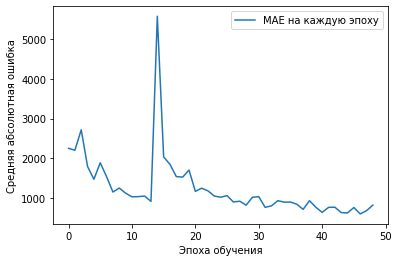

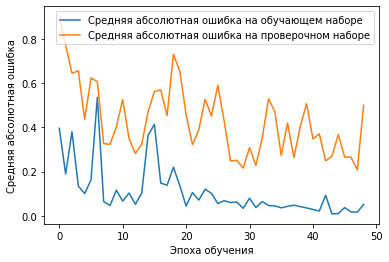

Время обучения эпохи: 549.318121433258с
Время с начала обучения: 549.3182005882263с
Время осталось (примерно): -7685.15763425827с

Эпоха 36
MAE: 1041.3888902313824


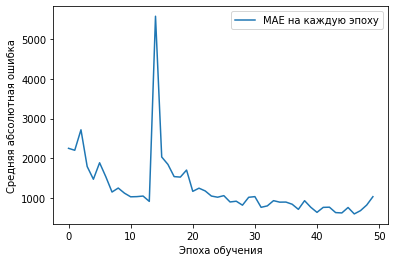

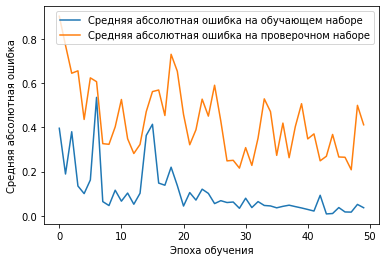

Время обучения эпохи: 565.4846303462982с
Время с начала обучения: 565.484708070755с
Время осталось (примерно): -8476.821084022522с

Эпоха 37
MAE: 810.5891950204235


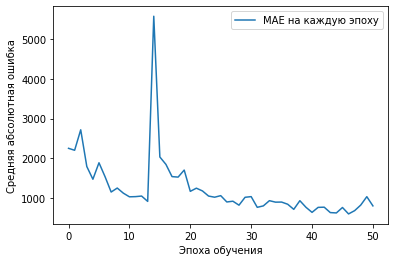

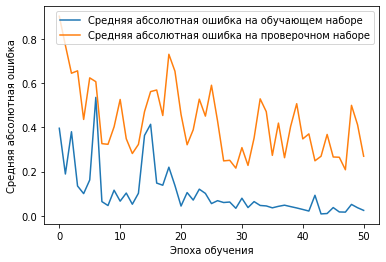

Время обучения эпохи: 580.1076271533966с
Время с начала обучения: 580.108410358429с
Время осталось (примерно): -9276.125812530518с

Эпоха 38
MAE: 578.7434722518004


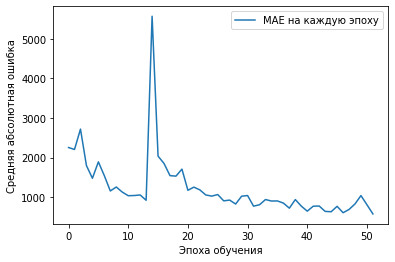

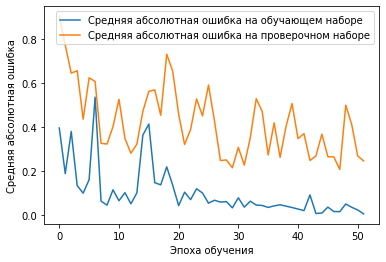

Время обучения эпохи: 594.9930880069733с
Время с начала обучения: 594.9931678771973с
Время осталось (примерно): -10108.80622291565с
Модель сохранена.

Эпоха 39
MAE: 983.6384808206757


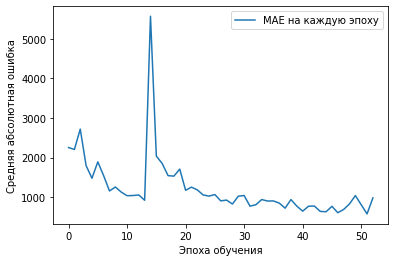

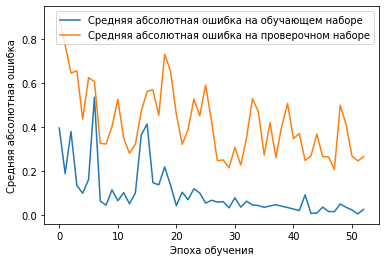

Время обучения эпохи: 611.6692233085632с
Время с начала обучения: 611.6713328361511с
Время осталось (примерно): -11003.081790447235с

Эпоха 40
MAE: 696.2603993727993


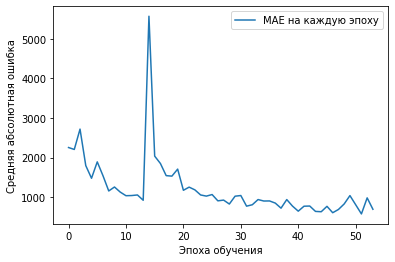

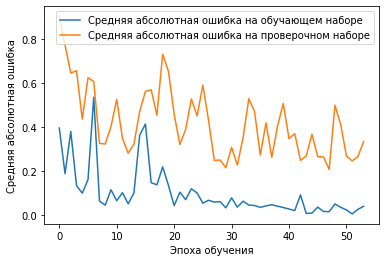

Время обучения эпохи: 628.2650527954102с
Время с начала обучения: 628.2727279663086с
Время осталось (примерно): -11930.146338701248с



In [ ]:
currtime = time.time()
startTime = currtime
epochs = 20
lr = 1e-4

history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    callbacks=[pltMae])

# print()
# print('Меняем шаг обучения на 1e-4')

# model.compile(optimizer=Adam(lr=1e-4), loss='mse')

# history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
#                     yTrainScaled[~valMask], 
#                     epochs=50, 
#                     validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
#                     yTrainScaled[valMask]), 
#                     verbose=0,
#                     callbacks=[pltMae])

# print()
# print('Меняем шаг обучения на 1e-5')

# model.compile(optimizer=Adam(lr=1e-5), loss='mse')

# history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
#                     yTrainScaled[~valMask], 
#                     epochs=50, 
#                     validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
#                     yTrainScaled[valMask]), 
#                     verbose=0,
#                     callbacks=[pltMae])


# pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])
# predUnscaled = yScaler.inverse_transform(pred).flatten()
# yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten()
# delta = predUnscaled - yTrainUnscaled
# absDelta = abs(delta)
# print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta)))

